# About the notebook

This notebook should be ran on the server. It's in charge of training both the mean and noise digital twins, and for performing a NAS to find the best Manifold Model.
The notebook was compartmentalized so one can run each "section" without rerunning the previous sections (assuming they also run the "Import Libraries" section).

This particular notebook includes an MNIST model that can incorporate rotations in its specification

## Import libraries

In [1]:
#super basic imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.random as random
import ipdb
import copy
import itertools
import os

#torch stuff
import torch
import pytorch_lightning as pl

#analysis / software for ml
#from ana_lib.custom_plmodels import *
from ana_lib.optuna_utils import *
from ana_lib.noise import *
from ana_lib.pat_utils import *
from ana_lib.pl_callbacks import *
from ana_lib.pl_utils import *
from ana_lib.plot_utils import *
from ana_lib.process_spectrum import *
from ana_lib.torch_loader import *
from ana_lib.utils import *
from digitaltwinNAS_small_com_swish import *

    
dirname = get_dirname()

class MLP_Reg(RegressionModel):
    def __init__(self, input_dim=None, output_dim=None, Nunits=None, Ncoms=1,identity_init=1,lr=1e-3):
        super().__init__()
        self.save_hyperparameters() #this appends all the inputs into self.hparams
        for (i, Nunit) in enumerate(Nunits): #writing more attributes to hyperparams that will appear on wandb
            self.hparams[f'ldim_{i}'] = Nunit
        self.hparams['Nlayers'] = len(Nunits) #repeat - adding Nlayers
        self.hparams['Ncoms'] = Ncoms
        self.hparams['identity_init'] = identity_init
        self.model = MLP(input_dim, output_dim, Nunits,Ncoms,identity_init) #Multilayer Perceptron pytorch model

    def forward(self, data):
        return self.model(data)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams['lr'])
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
        scheduler = default_scheduler(lr_scheduler) #a function basically to make up for pl_lightnings fault - please use it if you want to use a scheduler
#         return optimizer
        return [optimizer], [scheduler]


C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
#exec(open("ana_lib/gpu_par.py").read())


#### Function needed generically
def get_gpu_id_new():
    return 0

## Train mean digital twins

In [3]:

#Martin you will need to change some of this stuff 
sts=np.array([525,660,780])
lens=np.array([70,410,650])
Tmaxs=np.array([100,200,300])

xdim_list=np.array([196,98,56,28])

input_dims=[196,98,56,28]
output_dims=[196,98,56,28]

In [4]:
def process_Y(y,dim):
    return digitizex(y, dim)

def train_mean_dt(input_dim, output_dim,Tmax,layerstring,NAS=False,Ntrials=10):
    name = f"dt_data/xdim{input_dim}_Tmax{Tmax}_"+layerstring+"_mean_data"
    data = np.load(name+".npz",allow_pickle=True)
    Y = data["specs_list"]
    xlist = data["xlist"]

    Ys=list()
    Xs=list()
    
    meancheck=0.1 #Martin! This is used to reject any random misses. So you'd need to tune this parameter if >0
    for idx in range(Y.shape[1]):
        if np.mean(np.abs(Y[0,idx][:]))>meancheck:
            Ytemp = np.mean(np.array(Y[:,idx]),axis=0)
            Ys.append(process_Y(Ytemp,output_dim))
            Xs.append(xlist[idx,:])

    Yd=np.array(Ys)
    Xd=np.array(Xs)

    Ntotal=Yd.shape[0]
    Nval=int(0.1*Ntotal) #validation
    Ntrain=Ntotal-Nval
    
    B=np.mean(Yd)
    Yng=Yd-B
    A=np.max(np.abs(Yng))
    Yng=Yng/A
    np.savez(name + 'AB.npz',A=A,B=B) #Martin, I use this to normalize the outputs - see the digital twin data collection.
    

    Yt=Yng[:Ntrain,:]
    Yv=Yng[Ntrain:Ntrain+Nval,:]

    Xt=Xd[:Ntrain,:]
    Xv=Xd[Ntrain:Ntrain+Nval,:]
    
    Nbatch=100
    
    train_dataset = TensorDataset(torch.tensor(Xt).float(), torch.tensor(Yt).float())
    val_dataset = TensorDataset(torch.tensor(Xv).float(), torch.tensor(Yv).float())
    train_loader = DataLoader(dataset=train_dataset,batch_size=Nbatch)
    val_loader = DataLoader(dataset=val_dataset, batch_size=Nbatch)
    
    
    name = layerstring+ f"_in{input_dim}_out{output_dim}_Tmax{Tmax}"
    
    
    if NAS==True: #Only do once to get the idea of the right parameters to suggest. 
        dirname = get_dirname()
        project_name = f"{dirname}--mean_dt"  # the name that will appear in wandb
        max_epoch = 700 
        if layerstring=='l0': #Martin, my first layer is fixed 2*196-D dimensional with parameters on top, maybe change
            input_dimm=input_dim
        else:
            input_dimm=input_dim
            
        gpu_id = get_gpu_id_new()
        best_model_path=train_dig_twinNAS(Xd,Yng,input_dimm,output_dim,Ntrials,name, f"dt_models/mean_{name}.p",max_epoch,gpu_no=[gpu_id])
        mean_dt = MLP_Reg.load_from_checkpoint(best_model_path)   
        torch.save(mean_dt, f"dt_models/mean_{name}.p")        
    else:
        if layerstring == 'l0':
            model = MLP_Reg(input_dim, output_dim, [400], 2e-4) #FORCED TO BE 196!! #MARTIN!
        else:
            model = MLP_Reg(input_dim, output_dim, [210, 410], 0.0005)

        dirname = get_dirname()
        project_name = f"{dirname}--mean_dt"  # the name that will appear in wandb
        max_epoch = 800

        csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
        wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name)
        logger = [csv_logger, wandb_logger]

        checkpoint_file = os.path.join(csv_logger.log_dir, "{epoch}-{val_loss:.5f}")
        checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file)

        gpu_id = get_gpu_id_new()
        #print(gpu_id)

        trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=[gpu_id],
                             weights_summary=None, progress_bar_refresh_rate=0,
                             checkpoint_callback=checkpoint_cb, log_save_interval=50, row_log_interval=50)

        trainer.fit(model, train_loader, val_loader)

        
        mean_dt = MLP_Reg.load_from_checkpoint(checkpoint_cb.kth_best_model_path)
        
        torch.save(mean_dt, f"dt_models/mean_{name}.p")
    
    x, y = next(iter(val_loader))
    
    with torch.no_grad():
        y_pred = mean_dt(x)

    plot_grid(y_pred, y, ylim=(-1.5, 1.5));
    plt.savefig(f"monitor/mean_{name}.png", dpi=500)
    if NAS==False:
        wandb_logger.experiment.join()

#use if need to restart
def kill_gpu_processes():
    [ray.cancel(x) for x in ray_objs]
    
kill_gpu_processes()

## Train noise digital twins

In [5]:
Nλ = 2 #number of eigenvectors you keep for covariance matrix
def get_A(cov):
    if cov.ndim==0:
        A= np.sqrt(np.abs(cov))
    else:
        λ, Q = np.linalg.eig(cov)
        A = np.real(Q@np.diag(np.sqrt(np.abs(λ)))[:, :Nλ])
        A /= np.sign(np.sum(A, 0))
    return A

Nbatch = 100

In [6]:
def train_noise_dt(input_dim, output_dim,Tmax,layerstring,N=2000,NAS=False,Ntrials=10):
    name = layerstring+f"_in{input_dim}_out{output_dim}_Tmax{Tmax}"
    data = np.load(f"dt_data/xdim{input_dim}_Tmax{Tmax}_"+layerstring+"_noise_data.npz")

    specs_list = data["specs_list"][:,:N,:] #Don't use all the training data since the amount I require is probably overkill
    xlist = data["xlist"][:N,:]
    
    name2 = f"dt_data/xdim{input_dim}_Tmax{Tmax}_"+layerstring+"_mean_data"
    A=np.load(name2+'AB.npz')['A']
    B=np.load(name2+'AB.npz')['B']

    spectrums = np.array([[process_Y(s, output_dim)/A-B/A for s in specs] for specs in specs_list])
    spectrums = spectrums.swapaxes(0, 1)

    mean_data = np.mean(spectrums, axis=1)
    
    covs = np.array([np.cov(s.T) for s in spectrums])
    cov_x = np.concatenate((xlist, mean_data), axis=1)
    # cov_x = mean_data
    if output_dim>1:
        cov_data = covs.reshape(covs.shape[0], covs.shape[1]*covs.shape[2])

    As = np.array(list(map(get_A, covs)))

    A_x = np.concatenate((xlist, mean_data), axis=1)
    if output_dim>1:
        A_data = As.reshape(As.shape[0], As.shape[1]*As.shape[2])
    else:
        A_data = As
    train_loader, val_loader = np2loaders(A_x, A_data, Nbatch = 10)

    mlp_input_dim = next(iter(train_loader))[0].shape[1]
    if output_dim>1:
        mlp_output_dim = next(iter(train_loader))[1].shape[1]
    else:
        mlp_output_dim = 1
        
    dirname = get_dirname()
    project_name = f"{dirname}--noise_dt"  # the name that will appear in wandb
    
    if NAS==True: #Only do once to get the idea of the right parameters to suggest
        print('Starting NAS for digital noise twin')
        max_epoch = 1000          
        gpu_id = get_gpu_id_new()
        best_model_path=train_dig_twinNAS(A_x,A_data,mlp_input_dim,mlp_output_dim,Ntrials,name + '--noise_dt',f"dt_models/A_{name}.p",max_epoch,gpu_no=0)
        A_dt = MLP_Reg.load_from_checkpoint(best_model_path)   
        torch.save(A_dt, f"dt_models/A_{name}.p") ##note martin: we need to save the MLP_Reg object, not just the model! Here and above in the digital twin.     
    else:
        print('Training default model for noise twin')
        max_epoch = 200
        model = MLP_Reg(mlp_input_dim, mlp_output_dim, [600], 0.5e-4)
        #model = MLP_Reg(mlp_input_dim, mlp_output_dim, [1000,500,500], 0.5e-4)
        
        #logger stuff
        csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
        wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name)
        logger = [csv_logger, wandb_logger]

        #checkpoint
        checkpoint_file = os.path.join(csv_logger.log_dir, "{epoch}-{val_loss:.5f}")
        checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file)

        gpu_id = get_gpu_id_new()

        trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=[gpu_id],
                             weights_summary=None, progress_bar_refresh_rate=0,
                             checkpoint_callback=checkpoint_cb, log_save_interval=50, row_log_interval=4)

        trainer.fit(model, train_loader, val_loader)
        wandb_logger.experiment.join()

        A_dt = MLP_Reg.load_from_checkpoint(checkpoint_cb.kth_best_model_path)
     
        torch.save(A_dt, f"dt_models/A_{name}.p") ##note martin: we need to save the MLP_Reg object, not just the model! Here and above in the digital twin. 

    x, y = next(iter(val_loader))
    with torch.no_grad():
        y_pred = A_dt(x)

    cov_train_loader, cov_val_loader = np2loaders(A_x, covs, Nbatch=10)
    x_cov, y_cov = next(iter(cov_val_loader))
    if output_dim>1:
        fig, axs = plt.subplots(4, 2, figsize=(10, 8))

        for j in range(2):
            for ind in range(4):
                plt.sca(axs[ind, j])
                plt.plot(y[ind].reshape(output_dim, Nλ)[:, j],label='actual')
                plt.plot(y_pred[ind].reshape(output_dim, Nλ)[:, j],label='predicted')
        plt.legend()

        axs[0,0].set_title("A_1")
        axs[0,1].set_title("A_2")
        fig.savefig(f"monitor/A_{name}.png", dpi=200, bbox_inches="tight" )

        fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
        plt.subplots_adjust(hspace=0.05, wspace=0.02)
        problem_inds = [0, 1, 2]
        for (x_ind, p_ind) in enumerate(problem_inds):
            A_pred = y_pred[p_ind].reshape(output_dim, Nλ)

            cov_val = y_cov[p_ind]
            cov_pred = A_pred@A_pred.T
            vmax = 2*cov_val.max()

            plt.sca(axs[x_ind, 0])
            plt.imshow(cov_val, cmap="coolwarm", vmax=vmax, vmin=-vmax)
            plt.colorbar()

            plt.sca(axs[x_ind, 1])
            plt.imshow(cov_pred, cmap="coolwarm", vmax=vmax, vmin=-vmax)
            plt.colorbar()

            plt.sca(axs[x_ind, 2])
            plt.imshow(cov_val-cov_pred, cmap="coolwarm", vmax=vmax, vmin=-vmax)
            plt.colorbar()

        axs[0, 0].set_title("val cov")
        axs[0, 1].set_title("pred cov")
        axs[0, 2].set_title("val cov - pred cov")
        fig.savefig(f"monitor/cov_{name}.png", dpi=200, bbox_inches="tight" )

## NAS for Manifold Models

In [7]:
def relu_approx(x, factor=20.0):
    """
    A soft-relu function
    The default factor of 20.0 is descent for a turn on at around -0.1 
    """
    return F.softplus(x*factor)/factor
def clamp_lag(x, low=-1.0, high=1.0, factor=20): 
    """
    Lagrangian loss term to clamp the value of x between low and high.
    To play around with this code do:
    xlist = torch.tensor(np.linspace(-1, 2, 100))
    ylist = [clamp_lag(x, low=0, high=1, factor=20) for x in xlist]
    plt.plot(xlist, ylist)
    plt.grid()
    """
    return torch.mean(relu_approx(-(x-low), factor) + relu_approx(x-high, factor)) 
        
class ManifoldPlModelMNIST(ClassificationLagPlModel):
    def __init__(self, flist, dims,rot,lr,device,optimizer_name,gap, lag_amp=2.5, lag_factor=30.0):
        super().__init__()
        self.save_hyperparameters()
        #delete flist since it is a function which cannot be saved as JSON and will cause a bug...
        del self.hparams["flist"] 
        # writing more attributes to hyperparams that will appear on wandb
        for (i, Nunit) in enumerate(dims):
            self.hparams[f'ldim_{i}'] = Nunit
        self.hparams['Nlayers'] = len(dims[0])  #adding Nlayers
        self.hparams['Nchannels'] = len(dims) 
        self.hparams['optimizer']= optimizer_name
        self.hparams['gap']= gap
        self.factors = nn.ParameterList()
        self.offsets = nn.ParameterList()
        self.dims = dims
        self.rot = rot
        #self.ils = nn.ModuleList()
        #self.Ms = list()
        self.output_scale = nn.Parameter(torch.ones(1))
        self.output_offset  = nn.Parameter(torch.zeros(1))      

        N_channels = len(dims)
        self.N_channels = N_channels
        N_layers = len(dims[0])-1
        self.N_layers = N_layers
        
        #for n in range(N_channels):
        #    M=torch.zeros([196*2,dims[n][0]],requires_grad=False).float().to(device)
        #    idx2=0
        #    idx3=0
        #    for idx in range(2*196):
        #        M[idx,idx3]=1.
        #        idx2+=1
        #        if np.mod(idx2,2*196//dims[n][0])==0:
        #            idx3+=1
        #    
        #    self.Ms.append(M)
        
        
        dim_out = 0
        for n in range(N_channels):
            nlayers = len(flist)
            for dim in dims[n][:-1]:
                self.factors.append(nn.Parameter(torch.ones(dim)*0.9))
                self.offsets.append(nn.Parameter(torch.zeros(dim)))


            dim_out +=dims[n][-1]-2*gap
            
        self.flist = flist
        self.xPLMs = []
        
        self.gap=gap
        self.en=dims[-1][-1]-gap
                                        
        #self.il=nn.Linear(196,dims[0][0])
        #for dim in dims:
        #    self.ils.append(nn.Linear(196,dim[0]//2))
            
        self.ol = nn.Linear(dim_out,10)
        
        self.OL = torch.zeros([100,10],requires_grad=False).float().to(device) 
        
        n2=0
        for n1 in range(100):         
            if np.mod(n1,100//10) == 0 and n1 !=0:
                n2+=1               
            self.OL[n1,n2]=1
        print(self.OL)         
    
    def forward(self, x, save=False):
        
        self.xin = []
        self.xout = []
            
        #bnldx=0
        x0=x
        fdx=0
        for n in range(self.N_channels):
            for l in range(self.N_layers):        
                ldx=l+n*self.N_layers
                if l==0:
                    if self.rot[n]==True:
                        x0p = torch.reshape(x0,(x0.shape[0],14,14))
                        x0p = torch.rot90(x0p,1,[1,2])
                        x0p = torch.reshape(x0p,(x0.shape[0],196))
                        
                        x=x0p*self.factors[ldx]+self.offsets[ldx]
                    else:
                        x=x0*self.factors[ldx]+self.offsets[ldx]
                    self.xin.append(x)
                    #x = x*torch.matmul(self.Ms[n],self.factors[ldx])+torch.matmul(self.Ms[n],self.offsets[ldx])    
                else:
                    x=x*self.factors[ldx]+self.offsets[ldx]
                    self.xin.append(x) #MODIFIED FOR THE LAGRANGIAN
                    fdx+=1
                    
                x = x.clamp(-1, 1)
                x = self.flist[ldx](x)#+xin
                
                self.xout.append(x.detach())

            if n==0:
                xout=x[:,self.gap:self.en]#torch.cat([x0,x],dim=1)
            else:
                xout=torch.cat([xout,x[:,self.gap:self.en]],dim=1)

        #x = F.softmax(self.ol(xout),dim=1)
        x = torch.matmul(self.output_scale*xout/torch.max(xout,dim=1,keepdim=True).values+self.output_offset,self.OL)
        return x                 
    
    def lagrangian(self):
        """
        The lagrangian function that will be added to the loss.
        """
        lag_layers = [self.hparams.lag_amp*clamp_lag(x, -1.0, 1.0, self.hparams.lag_factor) for x in self.xin]
        #use stack to convert python list to pytorch tensor, then take the mean
        out = torch.mean(torch.stack(lag_layers))
        return out    
        
    
    def configure_optimizers(self):
        if self.hparams['optimizer'] == 'Adam':
            optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        elif self.hparams['optimizer'] == 'Adadelta':
            optimizer = optim.Adadelta(self.parameters())
        elif self.hparams['optimizer'] == 'SGD':
            optimizer = optim.SGD(self.parameters(),lr=self.hparams.lr,momentum=0.9)
        elif self.hparams['optimizer'] == 'Adagrad':            
            optimizer = optim.Adagrad(self.parameters(), lr=self.hparams.lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
        elif self.hparams['optimizer'] == 'ASGD':    
            optimizer = optim.ASGD(self.parameters(), lr=self.hparams.lr, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
        elif self.hparams['optimizer'] == 'SGD_LRdecay':          
            optimizer = optim.SGD(self.parameters(),lr=self.hparams.lr,momentum=0.9)
            torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False) 
        return optimizer       
    

In [8]:
"""
Functions that will be used in this cell...
"""
Nλ = 2
def get_dt(input_dim, output_dim, layerstring,idt,device):
    """
    Construct the digital twin function that has outputs mean with the noise added.
    Note, if don't want noise digital twin just return mean_dt
    """
    dtpath="dt_models/mean_"+layerstring+f"_in{input_dim}_out{output_dim}_Tmax{Tmaxs[idt]}.p"
    if os.path.isfile(dtpath):
        print('Model already exists for '+ dtpath)
        mean_dt = torch.load(dtpath).to(device)          
    else:
        print('Need to train model for ' + dtpath)
        train_mean_dt(input_dim,output_dim,Tmaxs[idt],layerstring,NAS=True,Ntrials=50)
        mean_dt = torch.load(dtpath).to(device)
        
    for param in mean_dt.parameters():
        param.requires_grad = False
        
    dtpath="dt_models/A_"+layerstring+f"_in{input_dim}_out{output_dim}_Tmax{Tmaxs[idt]}.p"  
    if os.path.isfile(dtpath):
        print('Model already exists for '+ dtpath)
        A_dt = torch.load(dtpath).to(device)
    else:
        print('Need to train model for ' + dtpath)
        train_noise_dt(input_dim,output_dim,Tmaxs[idt],layerstring,NAS=True,Ntrials=50)
        A_dt = torch.load(dtpath).to(device)
        
    for param in A_dt.parameters():
        param.requires_grad = False   
        
    f = make_dt_func(mean_dt, A_dt, output_dim, Nλ)
    return f

def train_model(project_name,name, dims, idts,rot,lr,max_epoch,train_loader,val_loader,ir,optimizer_name,path='None',gap=8):
    device = get_gpu_id_new()
    flist = list()
    for n in range(len(dims)):
        for l in range(len(dims[n])-1):
            flist.append(get_dt(dims[n][l], dims[n][l+1], 'l1',idts[n][l],device))
    model = ManifoldPlModelMNIST(flist, dims,rot,lr,device,optimizer_name,gap)
    print(model)
    
    if path!='None':
        model.load_state_dict(torch.load('NAS_run' + str(ir) +'.p'))

    #logger stuff
    csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
    wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name)
    logger = [csv_logger, wandb_logger]

    #checkpoint models
    checkpoint_file = os.path.join(csv_logger.log_dir, "{epoch}-{val_loss:.5f}")
    checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file)

    trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=[device],
                         weights_summary=None, progress_bar_refresh_rate=0,
                         checkpoint_callback=checkpoint_cb, log_save_interval=50, row_log_interval=4)

    trainer.fit(model, train_loader, val_loader)
    model.to(device) #trainer apparently changes it to cpu type all the time...

    #Run the same model many times since the noise creates maxima in the training
    accuracies, losses = test_plmodel(model, val_loader, Nrepeat=3)
    mean_accuracy = np.mean(accuracies)
    mean_loss = np.mean(losses)
    metrics = dict(epoch=trainer.current_epoch, 
                   val_accu_end=mean_accuracy,  val_loss_end=mean_loss)
    trainer.logger.log_metrics(metrics, step=trainer.global_step)
    wandb_logger.experiment.join()
    
    torch.save(model.state_dict(),'NAS_run' + str(ir) +'.p')
    
    return mean_accuracy, mean_loss, checkpoint_cb.kth_best_model_path

batch_size=50
from torchvision.datasets import MNIST
import torch
from torchvision import transforms
compress_factor=2
reshape_f = lambda x: torch.reshape(x[0, ::compress_factor, ::compress_factor], (-1, ))

transforms_noise = transforms.Compose([transforms.RandomAffine(15, translate=(0.0, 0.05), scale=(0.9, 1.1)), transforms.ToTensor(),  reshape_f])
train_loader = torch.utils.data.DataLoader(MNIST('.', train=True, download=True, transform=transforms_noise), batch_size=batch_size, shuffle=True)
transforms_noise = transforms.Compose([transforms.ToTensor(),  reshape_f])
val_loader = torch.utils.data.DataLoader(MNIST('.', train=False, download=True, transform=transforms_noise),batch_size=batch_size, shuffle=True) 

v=val_loader.dataset.data

reshape_f = lambda x: torch.reshape(x[0, ::compress_factor, ::compress_factor], (-1, ))
transform = transforms.Compose([transforms.ToTensor(), reshape_f])

compress_factor = 2 #Use either 1, 2 or 4! 
x = v[:, ::compress_factor, ::compress_factor]
x = x.reshape(x.shape[0], x.shape[1]**2)

y = val_loader.dataset.targets

yn=np.array(y)
xn=np.array(x)
xn=xn*1.0/255


Nval=6000//1
Ntest=(xn.shape[1]-Nval)//1

Xv=xn[:Nval,:]
Xtest=xn[Nval:,:]

Yv=yn[:Nval]
Ytest=yn[Nval:]


val_dataset = TensorDataset(torch.tensor(Xv).float(), torch.tensor(Yv))
test_dataset = TensorDataset(torch.tensor(Xtest).float(), torch.tensor(Ytest))

val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [9]:

Tmaxs=np.array([270])

input_dims=[196,98,56,28]
output_dims=[196,98,56,28]
project_name = 'DT_MNIST_NAS_dec28_'

[I 2021-03-17 08:28:26,271] Using an existing study with name '' instead of creating a new one.
wandb: Currently logged in as: pnn (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100v16sumSwish\v17 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,377999
lr-Adam,1e-05
_step,8399
_runtime,1285
_timestamp,1615985391
train_loss,0.14724
epoch,699
val_loss,0.14854


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▄▃▂▃▂▃▃▃▂▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


[I 2021-03-17 08:49:54,827] Trial 17 finished with value: 0.022064518183469772 and parameters: {'Nlayers': 4, 'Ncoms': 1, 'identity_init': 1, 'lr': 1e-05, 'Nunits1': 404.2728056037689, 'Nunits2': 639.0682319864994, 'Nunits3': 211.5705349409297}. Best is trial 3 with value: 0.009272251278162003.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100v16sumSwish\v18 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,377999
lr-Adam,1e-05
_step,8399
_runtime,1957
_timestamp,1615987351
train_loss,0.13336
epoch,699
val_loss,0.13567


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▅▅▅▄▄▃▄▄▄▃▃▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁


[I 2021-03-17 09:22:34,620] Trial 18 finished with value: 0.018407531082630157 and parameters: {'Nlayers': 3, 'Ncoms': 4, 'identity_init': 1, 'lr': 1e-05, 'Nunits1': 260.5706140732639, 'Nunits2': 251.25146536458197}. Best is trial 3 with value: 0.009272251278162003.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100v16sumSwish\v19 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,377999
lr-Adam,1e-05
_step,8399
_runtime,1700
_timestamp,1615989054
train_loss,0.13628
epoch,699
val_loss,0.13854


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▅▅▄▃▄▃▄▃▄▃▃▃▂▃▂▃▃▃▂▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


[I 2021-03-17 09:50:57,777] Trial 19 finished with value: 0.01919213868677616 and parameters: {'Nlayers': 3, 'Ncoms': 3, 'identity_init': 1, 'lr': 1e-05, 'Nunits1': 287.78544190994967, 'Nunits2': 246.44096679619827}. Best is trial 3 with value: 0.009272251278162003.
[I 2021-03-17 09:51:28,090] A new study created in RDB with name: 


Starting NAS for digital noise twin


wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,252
_timestamp,1615989340
val_loss,0.02028
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 09:55:43,459] Trial 0 finished with value: 0.0004066684050485492 and parameters: {'Nlayers': 5, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 157.24799527571483, 'Nunits2': 305.0592719184846, 'Nunits3': 187.29476502798337, 'Nunits4': 246.4505047951686}. Best is trial 0 with value: 0.0004066684050485492.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,333
_timestamp,1615989676
val_loss,0.0202
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:01:19,314] Trial 1 finished with value: 0.0003994662838522345 and parameters: {'Nlayers': 5, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 443.3057283458566, 'Nunits2': 475.96993207862226, 'Nunits3': 199.17897532142473, 'Nunits4': 190.25582637554135}. Best is trial 1 with value: 0.0003994662838522345.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v2 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,81
_timestamp,1615989760
val_loss,0.02177
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:02:43,617] Trial 2 finished with value: 0.0004609986790455878 and parameters: {'Nlayers': 2, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.01, 'Nunits1': 733.2433922284407}. Best is trial 1 with value: 0.0003994662838522345.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v3 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,221
_timestamp,1615989984
val_loss,0.02233
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▇▁▇█████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:06:28,112] Trial 3 finished with value: 0.00046461267629638314 and parameters: {'Nlayers': 5, 'Ncoms': 3, 'identity_init': 1, 'lr': 0.0031, 'Nunits1': 356.8782418524937, 'Nunits2': 266.6046053539642, 'Nunits3': 247.47533982157148, 'Nunits4': 166.97890401780253}. Best is trial 1 with value: 0.0003994662838522345.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v4 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,54
_timestamp,1615990042
val_loss,0.01998
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:07:26,136] Trial 4 finished with value: 0.000390573957702145 and parameters: {'Nlayers': 2, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.01, 'Nunits1': 397.16172056559685}. Best is trial 4 with value: 0.000390573957702145.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v5 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,192
_timestamp,1615990238
val_loss,0.02038
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████████████████████████▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:10:42,059] Trial 5 finished with value: 0.00041523933759890497 and parameters: {'Nlayers': 3, 'Ncoms': 4, 'identity_init': 0, 'lr': 1e-05, 'Nunits1': 276.05191285001047, 'Nunits2': 459.9126763176392}. Best is trial 4 with value: 0.000390573957702145.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v6 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,116
_timestamp,1615990358
val_loss,0.02315
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████████████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:12:41,169] Trial 6 finished with value: 0.0005359264905564487 and parameters: {'Nlayers': 2, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.0001, 'Nunits1': 394.73035357065476}. Best is trial 4 with value: 0.000390573957702145.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v7 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,8e-05
_step,1999
_runtime,38
_timestamp,1615990399
val_loss,0.0192
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:13:22,161] Trial 7 finished with value: 0.0003686955024022609 and parameters: {'Nlayers': 1, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.0031}. Best is trial 7 with value: 0.0003686955024022609.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v8 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,100
_timestamp,1615990502
val_loss,0.02131
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:15:05,637] Trial 8 finished with value: 0.0004403522762004286 and parameters: {'Nlayers': 2, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.01, 'Nunits1': 228.21102731019167}. Best is trial 7 with value: 0.0003686955024022609.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v9 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,37
_timestamp,1615990542
val_loss,0.01893
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:15:45,355] Trial 9 finished with value: 0.0003584009828045964 and parameters: {'Nlayers': 1, 'Ncoms': 2, 'identity_init': 1, 'lr': 0.001}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v10 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,236
_timestamp,1615990781
val_loss,0.0215
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:19:44,800] Trial 10 finished with value: 0.00046244380064308643 and parameters: {'Nlayers': 4, 'Ncoms': 5, 'identity_init': 1, 'lr': 0.000456, 'Nunits1': 329.57370649377697, 'Nunits2': 151.97308877831023, 'Nunits3': 195.15285192354426}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v11 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,2e-05
_step,1999
_runtime,38
_timestamp,1615990822
val_loss,0.019
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:20:25,509] Trial 11 finished with value: 0.0003609588020481169 and parameters: {'Nlayers': 1, 'Ncoms': 5, 'identity_init': 1, 'lr': 0.01}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v12 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,9e-05
_step,1999
_runtime,38
_timestamp,1615990863
val_loss,0.0191
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:21:06,196] Trial 12 finished with value: 0.00036477961111813784 and parameters: {'Nlayers': 1, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.001}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v13 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,97
_timestamp,1615990963
val_loss,0.02311
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:22:46,589] Trial 13 finished with value: 0.0005340832867659628 and parameters: {'Nlayers': 2, 'Ncoms': 5, 'identity_init': 0, 'lr': 1e-05, 'Nunits1': 198.0064844604055}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v14 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,80
_timestamp,1615991046
val_loss,0.02087
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████████████████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:24:09,946] Trial 14 finished with value: 0.0004354718839749694 and parameters: {'Nlayers': 2, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.0001, 'Nunits1': 179.65546960583458}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v15 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,68
_timestamp,1615991118
val_loss,0.02059
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███████████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:25:24,030] Trial 15 finished with value: 0.0004238874826114625 and parameters: {'Nlayers': 2, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.0001, 'Nunits1': 387.38879149534085}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v16 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,124
_timestamp,1615991248
val_loss,0.01993
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:27:32,228] Trial 16 finished with value: 0.00039643121999688447 and parameters: {'Nlayers': 2, 'Ncoms': 3, 'identity_init': 1, 'lr': 0.001, 'Nunits1': 686.2057755637661}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v17 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,214
_timestamp,1615991466
val_loss,0.01979
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████████████████████████▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:31:09,673] Trial 17 finished with value: 0.0003918282163795084 and parameters: {'Nlayers': 4, 'Ncoms': 2, 'identity_init': 0, 'lr': 1e-05, 'Nunits1': 656.5109294131667, 'Nunits2': 395.8677170966006, 'Nunits3': 214.4021156334935}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v18 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,125
_timestamp,1615991594
val_loss,0.02023
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:33:17,655] Trial 18 finished with value: 0.00040705493302084506 and parameters: {'Nlayers': 3, 'Ncoms': 2, 'identity_init': 1, 'lr': 0.000456, 'Nunits1': 223.47702335704705, 'Nunits2': 523.8077951326128}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v19 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,206
_timestamp,1615991803
val_loss,0.02084
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███████████▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:36:46,439] Trial 19 finished with value: 0.0004341085732448846 and parameters: {'Nlayers': 4, 'Ncoms': 3, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 305.2186508190478, 'Nunits2': 346.7130505854464, 'Nunits3': 187.96396044793272}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v20 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,369
_timestamp,1615992175
val_loss,0.02017
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:42:58,561] Trial 20 finished with value: 0.00040003753383643925 and parameters: {'Nlayers': 5, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 457.8075714705787, 'Nunits2': 175.8286110575532, 'Nunits3': 164.57675813964278, 'Nunits4': 216.85619234679896}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v21 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,114
_timestamp,1615992292
val_loss,0.0204
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,▇▁▇█████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:44:56,110] Trial 21 finished with value: 0.0003954661951866001 and parameters: {'Nlayers': 3, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.0031, 'Nunits1': 196.37730955091155, 'Nunits2': 290.29125202042854}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v22 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,42
_timestamp,1615992338
val_loss,0.01894
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:45:41,245] Trial 22 finished with value: 0.0003587834071367979 and parameters: {'Nlayers': 1, 'Ncoms': 2, 'identity_init': 1, 'lr': 0.001}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v23 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,43
_timestamp,1615992384
val_loss,0.02428
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
val_loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:46:27,733] Trial 23 finished with value: 0.0005892915651202202 and parameters: {'Nlayers': 1, 'Ncoms': 1, 'identity_init': 1, 'lr': 1e-05}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v24 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,381
_timestamp,1615992768
val_loss,0.02133
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:52:51,607] Trial 24 finished with value: 0.00045156534179113805 and parameters: {'Nlayers': 5, 'Ncoms': 4, 'identity_init': 1, 'lr': 0.001, 'Nunits1': 364.3236914938624, 'Nunits2': 554.1127989313698, 'Nunits3': 189.61027048792803, 'Nunits4': 220.43937425904403}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v25 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,98
_timestamp,1615992869
val_loss,0.02221
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:54:32,355] Trial 25 finished with value: 0.00046746188309043646 and parameters: {'Nlayers': 5, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.01, 'Nunits1': 348.3929384040187, 'Nunits2': 161.5578380629216, 'Nunits3': 189.32301901837096, 'Nunits4': 176.96044060149558}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v26 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,302
_timestamp,1615993174
val_loss,0.02132
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:59:37,675] Trial 26 finished with value: 0.00045449601020663977 and parameters: {'Nlayers': 4, 'Ncoms': 4, 'identity_init': 1, 'lr': 1e-05, 'Nunits1': 183.46409924914494, 'Nunits2': 545.4858776327906, 'Nunits3': 214.86335922127688}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v27 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,221
_timestamp,1615993398
val_loss,0.02022
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:03:22,171] Trial 27 finished with value: 0.00040884921327233315 and parameters: {'Nlayers': 5, 'Ncoms': 2, 'identity_init': 0, 'lr': 1e-05, 'Nunits1': 344.75465694492897, 'Nunits2': 374.4690840061405, 'Nunits3': 210.71931658388004, 'Nunits4': 209.97539592398434}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v28 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,239
_timestamp,1615993641
val_loss,0.02238
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:07:24,252] Trial 28 finished with value: 0.0004910554271191359 and parameters: {'Nlayers': 4, 'Ncoms': 4, 'identity_init': 1, 'lr': 0.01, 'Nunits1': 476.27866337772747, 'Nunits2': 199.57239263850406, 'Nunits3': 165.24594296034635}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v29 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,198
_timestamp,1615993842
val_loss,0.02032
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:10:45,564] Trial 29 finished with value: 0.0004060484643559903 and parameters: {'Nlayers': 3, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 206.93865410967646, 'Nunits2': 738.8228533445983}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v30 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,339
_timestamp,1615994184
val_loss,0.02069
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████████████████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:16:27,320] Trial 30 finished with value: 0.00042811036109924316 and parameters: {'Nlayers': 3, 'Ncoms': 5, 'identity_init': 0, 'lr': 1e-05, 'Nunits1': 396.0957756476899, 'Nunits2': 658.909275803457}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v31 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,40
_timestamp,1615994227
val_loss,0.01897
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:17:12,969] Trial 31 finished with value: 0.0003598023613449186 and parameters: {'Nlayers': 1, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.001}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v32 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,268
_timestamp,1615994502
val_loss,0.02075
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:21:46,049] Trial 32 finished with value: 0.0004305003385525197 and parameters: {'Nlayers': 5, 'Ncoms': 2, 'identity_init': 1, 'lr': 1e-05, 'Nunits1': 471.5290329692989, 'Nunits2': 398.0752864152081, 'Nunits3': 203.82432930125023, 'Nunits4': 201.06266218571398}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v33 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,434
_timestamp,1615994940
val_loss,0.02163
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:29:03,773] Trial 33 finished with value: 0.00046770350309088826 and parameters: {'Nlayers': 4, 'Ncoms': 5, 'identity_init': 1, 'lr': 0.001, 'Nunits1': 355.0438201371371, 'Nunits2': 193.09630251300726, 'Nunits3': 173.9161517141301}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v34 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,298
_timestamp,1615995241
val_loss,0.02074
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:34:04,189] Trial 34 finished with value: 0.00043011747766286135 and parameters: {'Nlayers': 3, 'Ncoms': 3, 'identity_init': 1, 'lr': 0.01, 'Nunits1': 615.3309190291577, 'Nunits2': 532.0151309385903}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v35 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,186
_timestamp,1615995430
val_loss,0.02064
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:37:13,620] Trial 35 finished with value: 0.00040788715705275536 and parameters: {'Nlayers': 3, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.01, 'Nunits1': 300.84070864377736, 'Nunits2': 254.85869076629754}. Best is trial 9 with value: 0.0003584009828045964.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v36 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,40
_timestamp,1615995473
val_loss,0.01891
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:37:56,179] Trial 36 finished with value: 0.00035777012817561626 and parameters: {'Nlayers': 1, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.001}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v37 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,82
_timestamp,1615995558
val_loss,0.02007
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:39:21,993] Trial 37 finished with value: 0.00040287006413564086 and parameters: {'Nlayers': 3, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 486.3183946205436, 'Nunits2': 259.45441598858247}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v38 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0001
_step,1999
_runtime,38
_timestamp,1615995600
val_loss,0.01936
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:40:03,628] Trial 38 finished with value: 0.00037475148565135896 and parameters: {'Nlayers': 1, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.0001}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v39 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,40
_timestamp,1615995643
val_loss,0.01896
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:40:47,024] Trial 39 finished with value: 0.00035937922075390816 and parameters: {'Nlayers': 1, 'Ncoms': 3, 'identity_init': 1, 'lr': 0.001}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v40 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0001
_step,1999
_runtime,42
_timestamp,1615995689
val_loss,0.01898
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:41:33,072] Trial 40 finished with value: 0.0003601588250603527 and parameters: {'Nlayers': 1, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.0001}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v41 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,39
_timestamp,1615995732
val_loss,0.01893
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:42:16,040] Trial 41 finished with value: 0.0003585282538551837 and parameters: {'Nlayers': 1, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.001}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v42 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,109
_timestamp,1615995845
val_loss,0.02003
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:44:08,285] Trial 42 finished with value: 0.0003974171122536063 and parameters: {'Nlayers': 3, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 322.573955857958, 'Nunits2': 217.73946531294877}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v43 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,41
_timestamp,1615995889
val_loss,0.01896
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:44:52,731] Trial 43 finished with value: 0.0003595649905037135 and parameters: {'Nlayers': 1, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.0031}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v44 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,89
_timestamp,1615995981
val_loss,0.02017
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:46:24,929] Trial 44 finished with value: 0.0004067349073011428 and parameters: {'Nlayers': 3, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.000456, 'Nunits1': 793.8645830516824, 'Nunits2': 204.56647723552328}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v45 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,117
_timestamp,1615996102
val_loss,0.02187
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:48:25,433] Trial 45 finished with value: 0.000476151384646073 and parameters: {'Nlayers': 2, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.001, 'Nunits1': 405.30984034365423}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v46 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,107
_timestamp,1615996212
val_loss,0.0201
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:50:15,620] Trial 46 finished with value: 0.0004038203042000532 and parameters: {'Nlayers': 2, 'Ncoms': 3, 'identity_init': 1, 'lr': 0.000456, 'Nunits1': 599.7381562469992}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v47 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,241
_timestamp,1615996456
val_loss,0.02033
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:54:19,380] Trial 47 finished with value: 0.0004027626127935946 and parameters: {'Nlayers': 4, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.001, 'Nunits1': 233.64689100661946, 'Nunits2': 183.7488510910481, 'Nunits3': 161.43457602136579}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v48 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,206
_timestamp,1615996665
val_loss,0.02064
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:57:48,859] Trial 48 finished with value: 0.0004234818334225565 and parameters: {'Nlayers': 3, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 365.26130572946323, 'Nunits2': 175.2286001617409}. Best is trial 36 with value: 0.00035777012817561626.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0_in70_out70_Tmax100--noise_dtv16sumSwish\v49 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,199
_timestamp,1615996867
val_loss,0.0211
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:01:11,014] Trial 49 finished with value: 0.00044537713984027505 and parameters: {'Nlayers': 4, 'Ncoms': 4, 'identity_init': 1, 'lr': 0.000456, 'Nunits1': 199.89223324869394, 'Nunits2': 170.86208755764218, 'Nunits3': 216.05258850447063}. Best is trial 36 with value: 0.00035777012817561626.


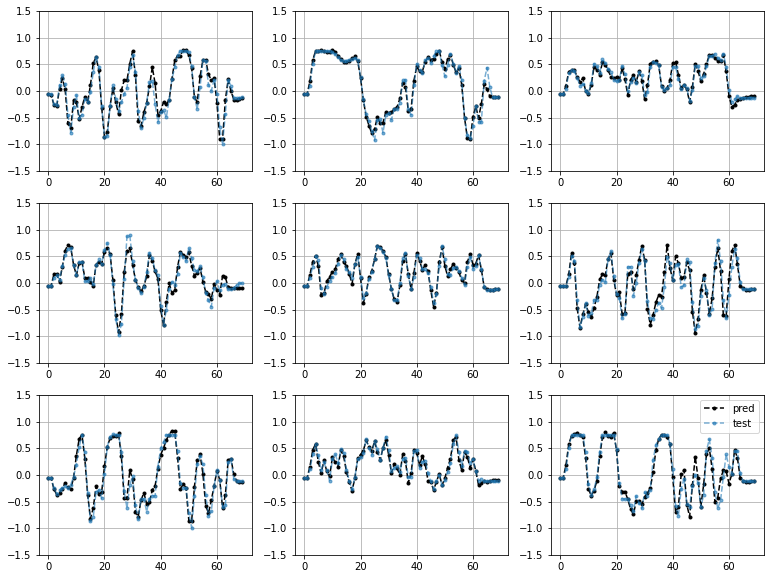

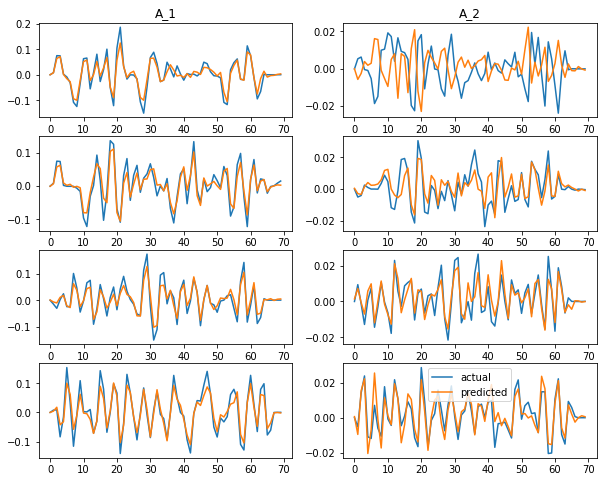

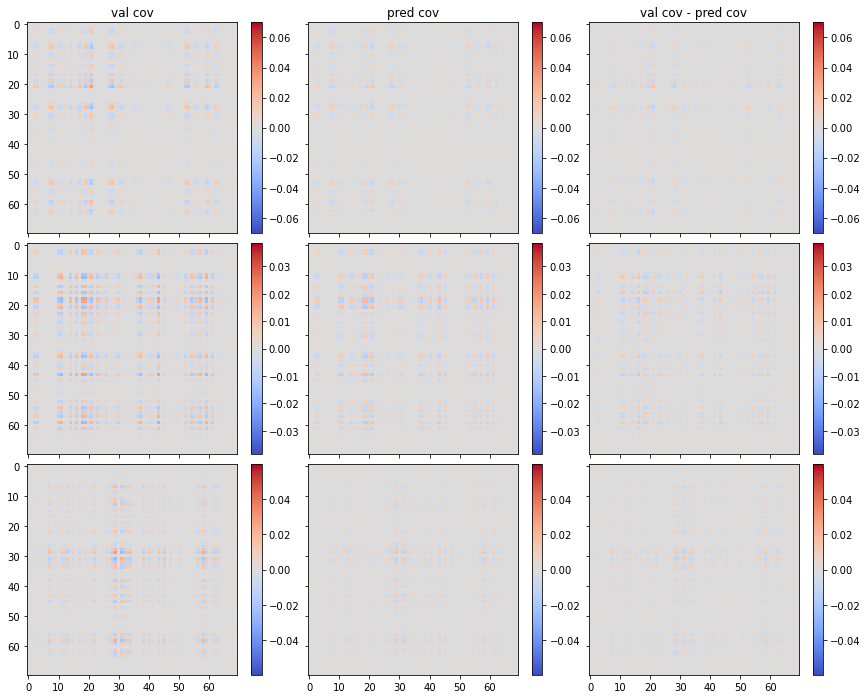

In [10]:
input_dim=70
output_dim=70
layerstring='l0'
idt=0
train_mean_dt(input_dim,output_dim,100,layerstring,NAS=True,Ntrials=50)
train_noise_dt(input_dim,output_dim,100,layerstring,NAS=True,Ntrials=50)